In [43]:
import pandas as pd
#from sklearn import datasets # sklearn comes with some toy datasets to practise
#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
#import seaborn as sns

import requests
import sys
from configspy import *
import spotipy
import json
import pandas as pd
import time
import functions as fu

from spotipy.oauth2 import SpotifyClientCredentials

In [44]:
songs_df=pd.read_csv(r'.\data\not_top100.csv')

In [17]:
def kmeans_clustering(audio_features_df, num_clusters, audio_feature_columns):
    # Select the columns for clustering
    data = audio_features_df[audio_feature_columns]

    # Create a K-Means model
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)

    # Fit the K-Means model to the data
    kmeans.fit(data)

    # Assign cluster labels to the original DataFrame
    audio_features_df['cluster_label'] = kmeans.labels_

    # Calculate the Calinski-Harabasz score
    calinski_score = calinski_harabasz_score(data, kmeans.labels_)
    
    # Plotting the clusters
    plt.figure(figsize=(5, 5))

    for cluster_label in range(num_clusters):
        cluster_data = audio_features_df[audio_features_df['cluster_label'] == cluster_label]
        plt.scatter(cluster_data[audio_feature_columns[0]], cluster_data[audio_feature_columns[1]], label=f'Cluster {cluster_label}')

    plt.title(f'K-Means Clustering (Calinski-Harabasz Score: {calinski_score:.2f})')
    plt.xlabel(audio_feature_columns[0])
    plt.ylabel(audio_feature_columns[1])
    plt.legend()
    plt.show()

    return audio_features_df, calinski_score


In [40]:

def cluster_audio_features(audio_features_df, audio_feature_columns, num_clusters):
    # Select the columns for clustering, excluding 'uri' and 'song_name'
    data = audio_features_df[audio_feature_columns]

    # Create a K-Means model
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)

    # Fit the K-Means model to the data
    kmeans.fit(data)

    # Assign cluster labels to the original DataFrame
    audio_features_df['cluster_label'] = kmeans.labels_

    return audio_features_df

def build_recommendation_model(clustered_df):
    # Create a k-NN model, excluding 'uri' and 'song_name'
    knn = NearestNeighbors(n_neighbors=4, metric='euclidean', n_jobs=-1)

    # Fit the k-NN model to the clustered data, excluding 'uri' and 'song_name'
    knn.fit(clustered_df[clustered_df.columns.difference(['uri', 'song_name', 'cluster_label'])])

    return knn

def song_recommender(clustered_df, recommendation_model, songs, num_recommendations=3):
    song_clusters = []
    for _, song in songs.iterrows():
        song_uri = song['uri']
        song_data = clustered_df[clustered_df['uri'] == song_uri]
        if not song_data.empty:
            cluster = int(song_data['cluster_label'].iloc[0])
            song_clusters.append(cluster)

    recommendations = []
    for cluster in song_clusters:
        cluster_songs = clustered_df[clustered_df['cluster_label'] == cluster]

        if len(cluster_songs) > num_recommendations:
            cluster_data = cluster_songs[clustered_df.columns.difference(['uri', 'song_name', 'cluster_label'])]
            indices = recommendation_model.kneighbors(cluster_data, num_recommendations + 1, return_distance=False)

            added_recommendations = 0
            for index in indices[0][1:]:
                if added_recommendations >= num_recommendations:
                    break
                if index < len(cluster_songs):
                    recommendations.append(cluster_songs.iloc[index]['uri'])
                    added_recommendations += 1

    return recommendations


def calculate_recommendation_score(recommendations, audio_features_df):
    recommendation_scores = []

    for uri in recommendations:
        # Find the song data in the audio_features_df
        song_data = audio_features_df[audio_features_df['uri'] == uri]

        # Calculate a score based on audio features (e.g., the mean of specific features)
        if not song_data.empty:
            # Customize the scoring function based on your preferences
            score = (song_data['danceability'] + song_data['energy']) / 2.0
            recommendation_scores.append((uri, score))

    # Sort the recommendations by score in descending order
    recommendation_scores.sort(key=lambda x: x[1], reverse=True)

    return recommendation_scores

def song_recommender_with_scores(clustered_df, recommendation_model, songs, audio_features_df, num_recommendations=3):
    song_clusters = []
    for _, song in songs.iterrows():
        song_uri = song['uri']
        song_data = clustered_df[clustered_df['uri'] == song_uri]
        if not song_data.empty:
            cluster = int(song_data['cluster_label'].iloc[0])
            song_clusters.append(cluster)

    recommendations = []
    for cluster in song_clusters:
        cluster_songs = clustered_df[clustered_df['cluster_label'] == cluster]

        if len(cluster_songs) > num_recommendations:
            cluster_data = cluster_songs[clustered_df.columns.difference(['uri', 'song_name', 'cluster_label'])]
            indices = recommendation_model.kneighbors(cluster_data, num_recommendations + 1, return_distance=False)

            added_recommendations = 0
            for index in indices[0][1:]:
                if added_recommendations >= num_recommendations:
                    break
                if index < len(cluster_songs):
                    recommendations.append(cluster_songs.iloc[index]['uri'])
                    added_recommendations += 1

    # Calculate scores for recommendations
    recommendation_scores = calculate_recommendation_score(recommendations, audio_features_df)

    return recommendation_scores


def drop_columns(dataframe, columns_to_drop):
    """
    Drops specified columns from a DataFrame.
    
    Parameters:
        dataframe (pandas.DataFrame): The DataFrame from which columns should be dropped.
        columns_to_drop (list): List of column names to drop from the DataFrame.

    Returns:
        pandas.DataFrame: A new DataFrame with the specified columns dropped.
    """
    return dataframe.drop(columns=columns_to_drop)

import requests

def get_spotify_url_from_uri(spotify_uri, access_token):
    # Define the Spotify API endpoint for track information
    endpoint = f'https://api.spotify.com/v1/tracks/{spotify_uri.split(":")[-1]}'

    # Set up the headers with the access token
    headers = {
        'Authorization': f'Bearer {access_token}'
    }

    try:
        # Make a GET request to the Spotify API
        response = requests.get(endpoint, headers=headers)

        if response.status_code == 200:
            # Parse the JSON response
            track_data = response.json()

            # Extract the external URL (Spotify URL) from the track data
            spotify_url = track_data.get('external_urls', {}).get('spotify')
            return spotify_url
        else:
            print(f"Failed to retrieve data. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    return None

def songs_df_preprocessing(songs_df):
    songs_df.drop_duplicates(subset='uri', keep='first', inplace=True)

    songs_df = songs_df.reset_index(drop=True)
    # Perform Label Encoding on the 'genre' column
    from sklearn.preprocessing import LabelEncoder

    # Create a LabelEncoder
    label_encoder = LabelEncoder()

    # Apply label encoding to the 'genre' column
    songs_df['genre_enc'] = label_encoder.fit_transform(songs_df['genre'])
    
    return songs_df

C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be

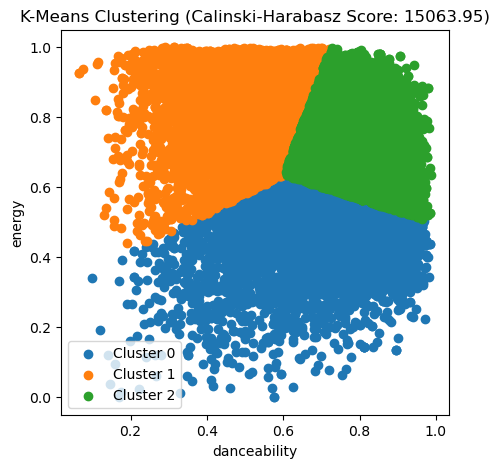

In [18]:
# Assuming audio_features_df is your audio features DataFrame and audio_feature_columns is a list of column names for clustering.
num_clusters = 3  # Set the number of clusters you want
audio_feature_columns=["danceability","energy"]
#audio_feature_columns=["danceability","tempo"]
clustered_df, calinski_score = kmeans_clustering(songs_df, num_clusters, audio_feature_columns)

Recommender

In [46]:
top_100 = pd.read_csv(r'.\data\top100.csv')
songs_df = pd.read_csv(r'.\data\not_top100.csv')

In [50]:
sp, access_token = fu.spotipy_connect()

AttributeError: module 'functions' has no attribute 'spotipy_connect'

In [49]:
#songs=songs_df.sample(n=5, random_state=100)
columns_to_remove = ["id", "track_href", "analysis_url", "duration_ms", "time_signature", "hot", "genre", "type"]
#top100,songs_df=fu.songlists_loader()

songs_df_dropped = drop_columns(songs_df, columns_to_remove)

songs_4model = fu.get_user_input_song_titles()

songs_4model = drop_columns(songs, columns_to_remove)

display(songs_4model)
print(songs[songs["uri"]==songs_4model["uri"]])

for uri in songs_4model["uri"]:
    spotify_uri = 'spotify:track:7oMFpfiP2K4frK1rhjMC2H'  # Replace with your URI
    access_token = 'your_access_token'  # Replace with your Spotify access token

spotify_url = get_spotify_url_from_uri(spotify_uri, access_token)

if spotify_url:
    print(f'Spotify URL: {spotify_url}')
else:
    print('Failed to retrieve the Spotify URL.')

AttributeError: module 'functions' has no attribute 'get_user_input_song_titles'

In [183]:
# Example usage:
# Assuming audio_features_df is your audio features DataFrame
# songs is a list of 3-5 songs with their audio features
# Choose the number of clusters for audio feature pairs
num_clusters = 5
audio_feature_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'genre_enc']

# Perform clustering
clustered_df = cluster_audio_features(songs_df_dropped, audio_feature_columns, num_clusters)

# Build a recommendation model
recommendation_model = build_recommendation_model(clustered_df)

# Recommend songs
recommendations = song_recommender(clustered_df, recommendation_model, songs_4model)
print(recommendations)

C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be

['spotify:track:3k8AeDhApZrHMeGGvtL3ev', 'spotify:track:5Xl4jZQFPGElFil9HDkb04', 'spotify:track:7b6Lp3fS8KjHY7LSxX5eCF', 'spotify:track:5Xl4jZQFPGElFil9HDkb04']


C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [184]:
# Example usage:
recommended_songs_df = find_songs_by_uris(songs_df, recommendations)
recommended_songs_df.shape

(3, 23)

In [185]:
recommended_songs_df

,song_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,hot,cluster_label,genre_enc
910,Hourglass,0.849,0.407,3,-9.494,0,0.2400,0.0163,0.0960,0.127,...,3k8AeDhApZrHMeGGvtL3ev,spotify:track:3k8AeDhApZrHMeGGvtL3ev,https://api.spotify.com/v1/tracks/3k8AeDhApZrH...,https://api.spotify.com/v1/audio-analysis/3k8A...,143000,4,Dark Trap,N,0,0
6923,Wulf of Akina,0.653,0.426,2,-13.608,1,0.0398,0.4140,0.0631,0.050,...,7b6Lp3fS8KjHY7LSxX5eCF,spotify:track:7b6Lp3fS8KjHY7LSxX5eCF,https://api.spotify.com/v1/tracks/7b6Lp3fS8KjH...,https://api.spotify.com/v1/audio-analysis/7b6L...,189832,3,Underground Rap,N,2,7
15275,Cheers (Drink To That),0.582,0.903,9,-3.550,1,0.0404,0.0182,0.0000,0.297,...,5Xl4jZQFPGElFil9HDkb04,spotify:track:5Xl4jZQFPGElFil9HDkb04,https://api.spotify.com/v1/tracks/5Xl4jZQFPGEl...,https://api.spotify.com/v1/audio-analysis/5Xl4...,261747,4,RnB,N,1,5


In [146]:
# Example usage:
#recommendation_scores = song_recommender_with_scores(clustered_df, recommendation_model, songs_4model, audio_features_df, num_recommendations=5)
#print(recommendation_scores)

In [ ]:
answer=Yes
while